# Gesture Recognition

In this group project, we build a 3D Conv model that will be able to predict the 5 gestures correctly. We imported the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imresize # this is deprecated
import datetime
import os

from imageio import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')
#from PIL import Image 

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, we read the folder names for training and validation. We also set the `batch_size` here. Note that we set the batch size in such a way that we are able to use the GPU in full capacity. We keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
#batch_size = 32 #experiment with the batch size

In [4]:
len(train_doc)

663

In [5]:
len(val_doc)

100

## Generator

This is one of the most important part of the code. In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. We have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] #create a list of image numbers we want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size,18,84,84,3)) # 18 is the number of images we use for each video, (84,84) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx):
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #cropped the images and resized them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32) #cropping the (120X160) image to make (120X120)
                    else:
                        #print("")
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction 
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #We yield the batch_data and the batch_labels


        
        # Code for the remaining data points which are left after full batches
        if(len(t)%batch_size!=0):
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3)) 
            batch_labels = np.zeros((len(t)%batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(len(t)%batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #cropped the images and resized them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    if image.shape[1] == 160:
                        image = resize(image[:,20:140,:],(84,84)).astype(np.float32)
                    else:
                        image = resize(image,(84,84)).astype(np.float32)
                    # Normalizing RGB image with mean subtraction
                    batch_data[folder,idx,:,:,0] = image[:,:,0] - 104
                    batch_data[folder,idx,:,:,1] = image[:,:,1] - 117
                    batch_data[folder,idx,:,:,2] = image[:,:,2] - 123
                                        
                batch_labels[folder, int(t[folder + (num_batches*(len(t)%batch_size))].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #We yield the batch_data and the batch_labels

Note: A video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30  # Number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model

Here we make the model using different functionalities that Keras provides. We used `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We can also use `TimeDistributed` while building a Conv2D + RNN model. Also, the last layer is the softmax. Designed the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# Model here

Input_shape = (18, 84, 84, 3)

model = Sequential()
model.add(Conv3D(64, (3,3,3), padding='same', input_shape=(18,84,84,3)))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

model.add(Conv3D(128, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Conv3D(256, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling3D(pool_size=(2,2,2), strides=(2,2,2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

2022-11-20 14:45:15.970508: W tensorflow/stream_executor/platform/default/dso_loader.cc:65] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-11-20 14:45:15.970557: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-20 14:45:15.970591: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist


In [14]:
# Model compile
optimiser = optimizers.SGD(learning_rate = 0.01)
#optimiser = optimizers.SGD(lr=0.001, decay=1e-6)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 18, 84, 84, 64)    5248      
                                                                 
 batch_normalization_4 (Batc  (None, 18, 84, 84, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 18, 84, 84, 64)    0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 9, 42, 84, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 9, 42, 84, 128)    221312    
                                                                 
 batch_normalization_5 (Batc  (None, 9, 42, 84, 128)  

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
batch_size = 32
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq = 'epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, we'll be able to save the model at the end of each epoch.

In [18]:
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/30


2022-11-20 05:12:54.925979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 6.4849 - categorical_accuracy: 0.3017Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: saving model to model_init_2022-11-2005_10_49.405905/model-00001-6.48495-0.30166-11.42143-0.21000.h5
21/21 [==============================] - 100s 5s/step - loss: 6.4849 - categorical_accuracy: 0.3017 - val_loss: 11.4214 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 1.5441 - categorical_accuracy: 0.4736
Epoch 00002: saving model to model_init_2022-11-2005_10_49.405905/model-00002-1.54406-0.47360-10.04351-0.19000.h5
21/21 [==============================] - 98s 5s/step - loss: 1.5441 - categorical_accuracy: 0.4736 - val_loss: 10.0435 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.3276 - categorical_accuracy: 0.5249
Epoch 00003: saving model to model_init_2022-11-2005_10_49.405905

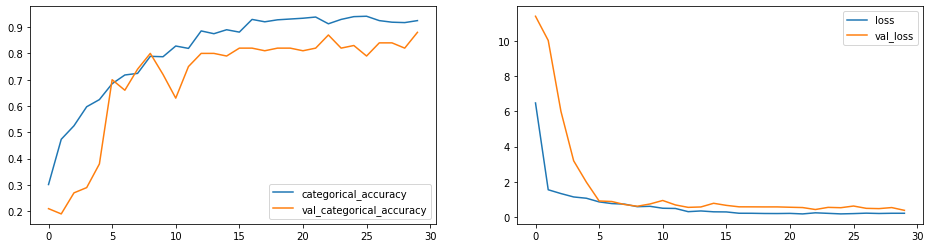

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
axes[0].plot(model.history.history['categorical_accuracy'])   
axes[0].plot(model.history.history['val_categorical_accuracy'])
axes[0].legend(['categorical_accuracy','val_categorical_accuracy'])

axes[1].plot(model.history.history['loss'])   
axes[1].plot(model.history.history['val_loss'])
axes[1].legend(['loss','val_loss'])

## Predictions

In [8]:
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

In [34]:
t = np.random.permutation(val_doc)

In [42]:
# All types of action : Left swipe, Right swipe, Stop, Thumbs down, Thumbs up
# We will give this 5 action in these order to see model is able to predict all 5 action correctly
print(t[1].split(';'))
print(t[0].split(';'))
print(t[4].split(';'))
print(t[10].split(';'))
print(t[5].split(';'))

['WIN_20180925_17_43_01_Pro_Left_Swipe_new', 'Left_Swipe_new', '0\n']
['WIN_20180907_15_57_43_Pro_Right Swipe_new', 'Right Swipe_new', '1\n']
['WIN_20180926_17_08_11_Pro_Stop_new', 'Stop_new', '2\n']
['WIN_20180925_17_35_29_Pro_Thumbs_Down_new', 'Thumbs_Down_new', '3\n']
['WIN_20180907_15_52_05_Pro_Thumbs Up_new', 'Thumbs Up_new', '4\n']


In [44]:
images = os.listdir(val_path+'/'+t[1].strip().split(';')[0])

In [45]:
images[0]

'WIN_20180925_17_43_01_Pro_00007.png'

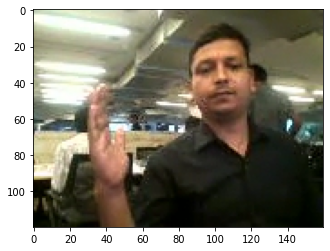

In [47]:
image_1=imageio.imread(val_path+'/'+ t[1].strip().split(';')[0]+'/'+ images[0]).astype(np.float32)
plt.imshow(image_1.astype('uint8'))

In [48]:
img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
actions = [1,0,4,10,5]

In [49]:
actions[0]

1

In [52]:

def Preprocess_data(img_idx, action):
    batch_data = np.zeros((5,18,84,84,3))
    batch_labels = np.zeros((5,5))
    for i in range(5): 
        images = os.listdir(val_path+'/'+t[actions[i]].strip().split(';')[0])
        for idx,item in enumerate(img_idx):
            image = imageio.imread(val_path+'/'+ t[actions[i]].strip().split(';')[0]+'/'+ images[item]).astype(np.float32)

            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes
            if image.shape[1] == 160:
                image = resize(image[:,20:140,:],(84,84)).astype(np.float32) #cropping the (120X160) image to make (120X120)
            else:
                #print("")
                image = resize(image,(84,84)).astype(np.float32)
            # Normalizing RGB image with mean subtraction 
            batch_data[i,idx,:,:,0] = image[:,:,0] - 104
            batch_data[i,idx,:,:,1] = image[:,:,1] - 117
            batch_data[i,idx,:,:,2] = image[:,:,2] - 123

        batch_labels[i, int(t[action[i]].split(';')[2])] = 1
    return batch_data, batch_labels

In [53]:
batch_1 = Preprocess_data(img_idx, actions)

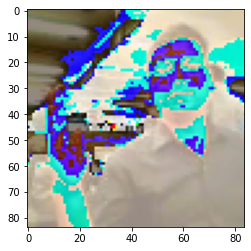

In [55]:
plt.imshow(batch_1[0][0][0].astype('uint8'))

In [31]:
model.load_weights('/home/dl_content/Upgrad DL/Gesture Recognition Assignment/model_init_2022-11-2005_10_49.405905/model-00030-0.20564-0.92459-0.37276-0.88000.h5')

In [56]:
output = model.predict(batch_1[0])

In [58]:
# We can see that model is able predict all 5 actions correctly
np.argmax(output, axis=0)

array([0, 1, 2, 3, 4])